# **WEEK 9**

## Dataset 1: Web page Phishing Detection Dataset

### **Gradient Boost, learning rate, number of estimators, tree depth, and regularization**

In [ ]:
# --- Section 1: Imports & Config ---
import re
import numpy as np
import pandas as pd


from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.impute import SimpleImputer
from sklearn.ensemble import GradientBoostingClassifier

import matplotlib.pyplot as plt
import seaborn as sns

RANDOM_STATE = 42
plt.rcParams["figure.dpi"] = 130
sns.set(style="whitegrid")

In [7]:
# --- Section 2: Load Dataset ---
import kagglehub

path = kagglehub.dataset_download("shashwatwork/web-page-phishing-detection-dataset")
dataset1 = pd.read_csv(path + "/dataset_phishing.csv")

# Drop obvious index columns if present
for c in ["Index", "index", "Unnamed: 0"]:
    if c in dataset1.columns:
        dataset1 = dataset1.drop(columns=[c])

dataset1.head(3)

,url,length_url,length_hostname,ip,nb_dots,nb_hyphens,nb_at,nb_qm,nb_and,nb_or,...,domain_in_title,domain_with_copyright,whois_registered_domain,domain_registration_length,domain_age,web_traffic,dns_record,google_index,page_rank,status
0,http://www.crestonwood.com/router.php,37,19,0,3,0,0,0,0,0,...,0,1,0,45,-1,0,1,1,4,legitimate
1,http://shadetreetechnology.com/V4/validation/a...,77,23,1,1,0,0,0,0,0,...,1,0,0,77,5767,0,0,1,2,phishing
2,https://support-appleld.com.secureupdate.duila...,126,50,1,4,1,0,1,2,0,...,1,0,0,14,4004,5828815,0,1,0,phishing


In [8]:
# --- Section 3: Target Mapping (simple) + Features ---

if "status" not in dataset1.columns:
    raise ValueError("Expected target column 'status' not found.")

y_raw = dataset1["status"]

# If 'status' is text (e.g., 'legitimate' / 'phishing'), map to 1/0; else cast to int
if y_raw.dtype == "object":
    y = y_raw.str.lower().map({"legitimate": 1, "phishing": 0}).astype(int)
else:
    y = y_raw.astype(int)

print("Target counts after mapping:")
print(y.value_counts(dropna=False))

# Features (everything except target)
X = dataset1.drop(columns=["status"])

Target counts after mapping:
status
1    5715
0    5715
Name: count, dtype: int64


In [9]:
# --- Section 4: URL/Text Feature Engineering → Numeric ---

def engineer_url_features(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    object_cols = df.select_dtypes(include=["object"]).columns.tolist()

    # Heuristic: treat columns that look like URL/host/domain/link specially
    url_like = [c for c in object_cols if re.search(r"url|link|host|domain", c, re.IGNORECASE)]

    for c in url_like:
        s = df[c].astype(str)

        # Basic character-level signals
        df[f"{c}__len"]         = s.apply(len)
        df[f"{c}__dots"]        = s.apply(lambda x: x.count("."))
        df[f"{c}__hyphens"]     = s.apply(lambda x: x.count("-"))
        df[f"{c}__slashes"]     = s.apply(lambda x: x.count("/"))
        df[f"{c}__digits"]      = s.apply(lambda x: sum(ch.isdigit() for ch in x))
        df[f"{c}__at"]          = s.apply(lambda x: x.count("@"))
        df[f"{c}__qmarks"]      = s.apply(lambda x: x.count("?"))
        df[f"{c}__eq"]          = s.apply(lambda x: x.count("="))
        df[f"{c}__percents"]    = s.apply(lambda x: x.count("%"))
        df[f"{c}__underscores"] = s.apply(lambda x: x.count("_"))

        # Keyword flags (rough phishy cues)
        def has_any(x, words):
            lx = x.lower()
            return int(any(w in lx for w in words))

        df[f"{c}__kw_login"]    = s.apply(lambda x: has_any(x, ["login","signin","account","verify","password","update"]))
        df[f"{c}__kw_bank"]     = s.apply(lambda x: has_any(x, ["bank","paypal","secure","confirm"]))
        df[f"{c}__kw_free"]     = s.apply(lambda x: has_any(x, ["free","win","prize"]))
        df[f"{c}__kw_click"]    = s.apply(lambda x: has_any(x, ["click","here"]))

        # IP present in URL?
        ip_pattern = r"(\d{1,3}\.){3}\d{1,3}"
        df[f"{c}__has_ip"]      = s.str.contains(ip_pattern).astype(int)

    # Drop all original object columns (we keep only engineered numeric signals)
    df = df.drop(columns=object_cols, errors="ignore")
    return df

X_fe = engineer_url_features(X)
X_fe.head(3)


/var/folders/bt/wl503sb91lq9s04260qbk03r0000gn/T/ipykernel_58963/965109070.py:37: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  df[f"{c}__has_ip"]      = s.str.contains(ip_pattern).astype(int)


,length_url,length_hostname,ip,nb_dots,nb_hyphens,nb_at,nb_qm,nb_and,nb_or,nb_eq,...,url__at,url__qmarks,url__eq,url__percents,url__underscores,url__kw_login,url__kw_bank,url__kw_free,url__kw_click,url__has_ip
0,37,19,0,3,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,77,23,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,126,50,1,4,1,0,1,2,0,3,...,0,1,3,0,2,1,1,0,0,0


In [10]:
# --- Section 5: Split & Imputation (no scaling needed for trees) ---

X_train, X_test, y_train, y_test = train_test_split(
    X_fe, y, test_size=0.30, random_state=RANDOM_STATE, stratify=y
)

imputer = SimpleImputer(strategy="median")
X_train_num = imputer.fit_transform(X_train)
X_test_num  = imputer.transform(X_test)

feature_names = X_train.columns.tolist()

Baseline GBC — Accuracy: 0.961 | F1: 0.961

              precision    recall  f1-score   support

           0      0.961     0.960     0.961      1715
           1      0.960     0.961     0.961      1714

    accuracy                          0.961      3429
   macro avg      0.961     0.961     0.961      3429
weighted avg      0.961     0.961     0.961      3429



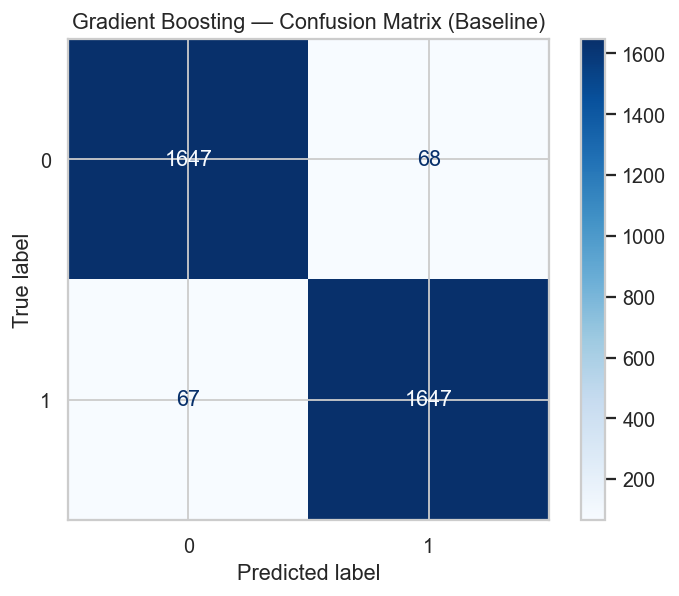

In [11]:
# --- Section 6: Baseline Gradient Boosting ---
gb_baseline = GradientBoostingClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=3,
    subsample=1.0,
    random_state=RANDOM_STATE
)
gb_baseline.fit(X_train_num, y_train)

y_pred = gb_baseline.predict(X_test_num)
acc = accuracy_score(y_test, y_pred)
f1  = f1_score(y_test, y_pred)

print(f"Baseline GBC — Accuracy: {acc:.3f} | F1: {f1:.3f}\n")
print(classification_report(y_test, y_pred, digits=3))

ConfusionMatrixDisplay.from_estimator(gb_baseline, X_test_num, y_test, cmap="Blues")
plt.title("Gradient Boosting — Confusion Matrix (Baseline)")
plt.show()

In [12]:
# --- Section 7: Helpers (evaluate + plot curves) ---
def evaluate_model(model, Xtr, ytr, Xte, yte):
    model.fit(Xtr, ytr)
    pred = model.predict(Xte)
    return accuracy_score(yte, pred), f1_score(yte, pred)

def plot_metric_curve(xvals, accs, f1s, xlabel, title):
    fig, ax = plt.subplots()
    sns.lineplot(x=xvals, y=accs, marker="o", label="Accuracy", ax=ax)
    sns.lineplot(x=xvals, y=f1s, marker="s", label="F1", ax=ax)
    ax.set_xlabel(xlabel)
    ax.set_ylabel("Score")
    ax.set_title(title)
    ax.legend()
    plt.show()

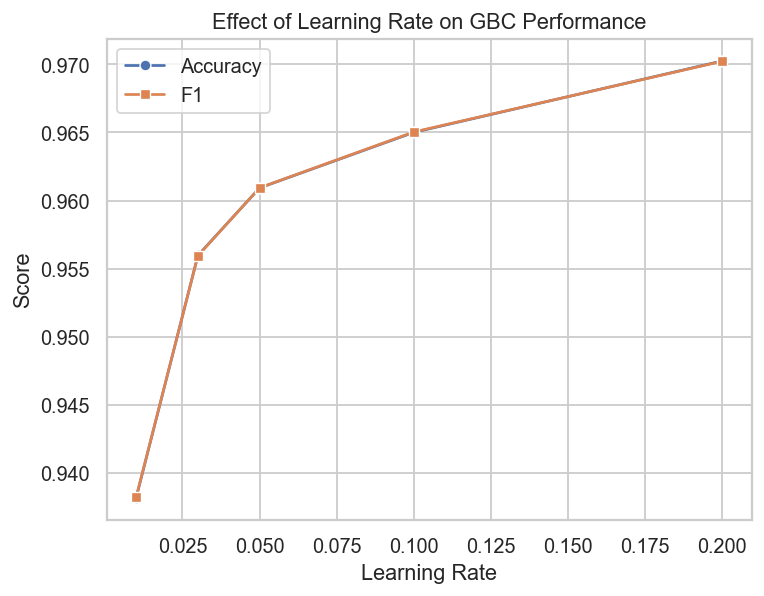

,learning_rate,accuracy,f1
0,0.01,0.938174,0.938228
1,0.03,0.955964,0.955938
2,0.05,0.960922,0.960933
3,0.10,0.965004,0.965035
4,0.20,0.970254,0.970228


In [13]:
# --- Section 8: Learning Rate Sweep ---
lrs = [0.01, 0.03, 0.05, 0.1, 0.2]
accs, f1s = [], []

for lr in lrs:
    model = GradientBoostingClassifier(
        n_estimators=200,        # more trees to offset small LR
        learning_rate=lr,
        max_depth=3,
        subsample=1.0,
        random_state=RANDOM_STATE
    )
    acc, f1 = evaluate_model(model, X_train_num, y_train, X_test_num, y_test)
    accs.append(acc); f1s.append(f1)

plot_metric_curve(lrs, accs, f1s, "Learning Rate", "Effect of Learning Rate on GBC Performance")
pd.DataFrame({"learning_rate": lrs, "accuracy": accs, "f1": f1s})

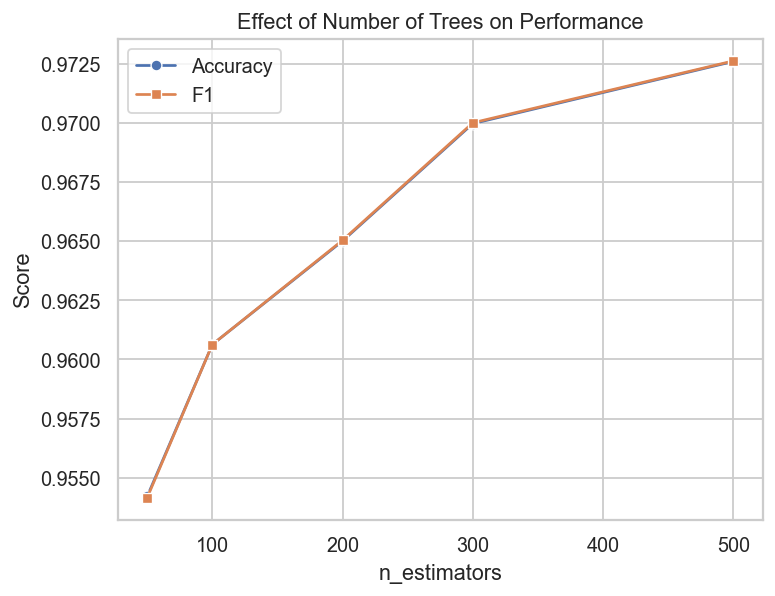

,n_estimators,accuracy,f1
0,50,0.954214,0.954161
1,100,0.960630,0.960630
2,200,0.965004,0.965035
3,300,0.969962,0.969997
4,500,0.972587,0.972611


In [14]:
# --- Section 9: Number of Trees Sweep ---
trees = [50, 100, 200, 300, 500]
accs, f1s = [], []

for n in trees:
    model = GradientBoostingClassifier(
        n_estimators=n,
        learning_rate=0.1,
        max_depth=3,
        subsample=1.0,
        random_state=RANDOM_STATE
    )
    acc, f1 = evaluate_model(model, X_train_num, y_train, X_test_num, y_test)
    accs.append(acc); f1s.append(f1)

plot_metric_curve(trees, accs, f1s, "n_estimators", "Effect of Number of Trees on Performance")
pd.DataFrame({"n_estimators": trees, "accuracy": accs, "f1": f1s})

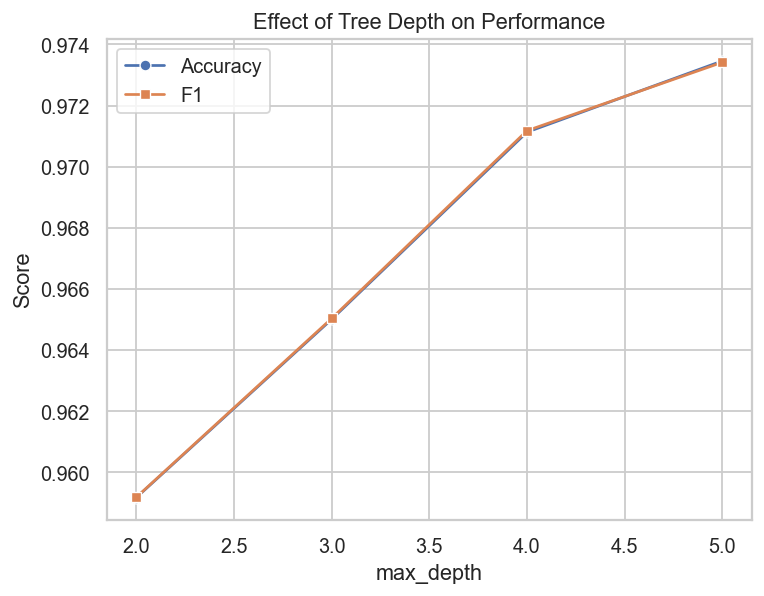

,max_depth,accuracy,f1
0,2,0.959172,0.959184
1,3,0.965004,0.965035
2,4,0.971129,0.971179
3,5,0.973462,0.973415


In [15]:
# --- Section 10: max_depth Sweep ---
depths = [2, 3, 4, 5]
accs, f1s = [], []

for d in depths:
    model = GradientBoostingClassifier(
        n_estimators=200,
        learning_rate=0.1,
        max_depth=d,
        subsample=1.0,
        random_state=RANDOM_STATE
    )
    acc, f1 = evaluate_model(model, X_train_num, y_train, X_test_num, y_test)
    accs.append(acc); f1s.append(f1)

plot_metric_curve(depths, accs, f1s, "max_depth", "Effect of Tree Depth on Performance")
pd.DataFrame({"max_depth": depths, "accuracy": accs, "f1": f1s})

In [16]:
# --- Section 11: Regularization Sweep (subsample & min_samples_leaf) ---
settings = [
    (1.0, 1),
    (0.8, 3),
    (0.6, 5),
    (0.5, 10),
    (0.4, 20),
]

rows = []
for subsample, min_leaf in settings:
    model = GradientBoostingClassifier(
        n_estimators=300,
        learning_rate=0.05,   # slightly smaller LR when subsampling
        max_depth=3,
        subsample=subsample,
        min_samples_leaf=min_leaf,
        random_state=RANDOM_STATE
    )
    acc, f1 = evaluate_model(model, X_train_num, y_train, X_test_num, y_test)
    rows.append((subsample, min_leaf, acc, f1))

reg_df = pd.DataFrame(rows, columns=["subsample", "min_samples_leaf", "accuracy", "f1"])
reg_df

,subsample,min_samples_leaf,accuracy,f1
0,1.0,1,0.964421,0.964494
1,0.8,3,0.963546,0.963589
2,0.6,5,0.963546,0.963525
3,0.5,10,0.962380,0.962358
4,0.4,20,0.961796,0.961774


Final GBC — Accuracy: 0.964 | F1: 0.964


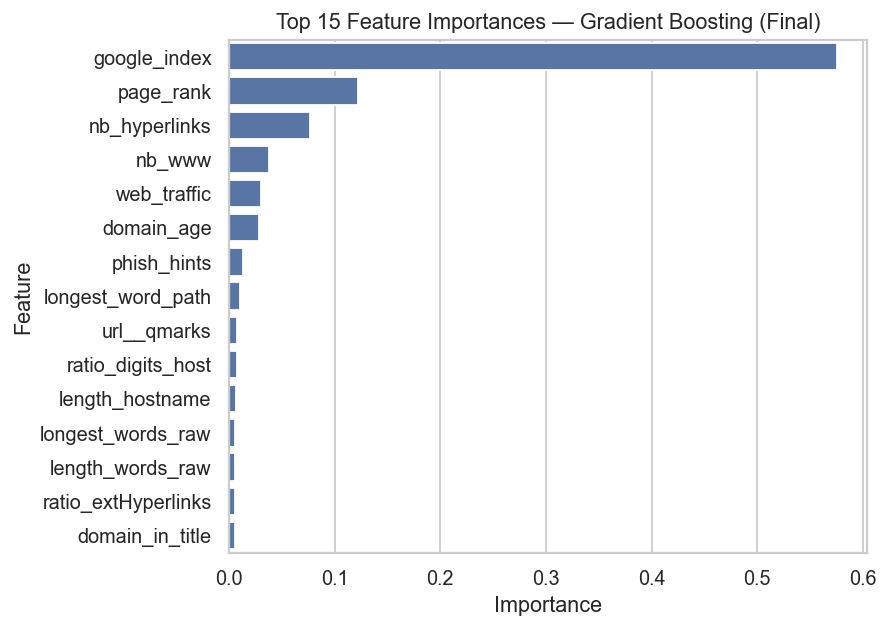

In [17]:
# --- Section 12: Final Model & Feature Importances ---
gb_final = GradientBoostingClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=3,
    subsample=0.8,
    min_samples_leaf=5,
    random_state=RANDOM_STATE
)
gb_final.fit(X_train_num, y_train)
y_hat = gb_final.predict(X_test_num)

print(f"Final GBC — Accuracy: {accuracy_score(y_test, y_hat):.3f} | F1: {f1_score(y_test, y_hat):.3f}")

# Feature importances
importances = pd.Series(gb_final.feature_importances_, index=feature_names)
topk = importances.sort_values(ascending=False).head(15)

plt.figure(figsize=(7, 5))
sns.barplot(x=topk.values, y=topk.index)
plt.title("Top 15 Feature Importances — Gradient Boosting (Final)")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

In [18]:
# --- Section 13: Compact Metrics Summary ---
summary_rows = []

def quick_eval(name, model):
    acc, f1 = evaluate_model(model, X_train_num, y_train, X_test_num, y_test)
    summary_rows.append((name, acc, f1))

quick_eval("Baseline (100, lr=0.1, depth=3)", gb_baseline)
quick_eval("n=300, lr=0.1, depth=3", GradientBoostingClassifier(n_estimators=300, learning_rate=0.1, max_depth=3, random_state=RANDOM_STATE))
quick_eval("n=200, lr=0.05, depth=3", GradientBoostingClassifier(n_estimators=200, learning_rate=0.05, max_depth=3, random_state=RANDOM_STATE))
quick_eval("Final tuned", gb_final)

metrics_df = pd.DataFrame(summary_rows, columns=["model", "accuracy", "f1"]).sort_values("f1", ascending=False)
metrics_df.reset_index(drop=True, inplace=True)
metrics_df

,model,accuracy,f1
0,"n=300, lr=0.1, depth=3",0.969962,0.969997
1,Final tuned,0.964129,0.964192
2,"n=200, lr=0.05, depth=3",0.960922,0.960933
3,"Baseline (100, lr=0.1, depth=3)",0.960630,0.960630


#### **Conclusions**

**The Gradient Boosting** experiments show that the model performs exceptionally well, achieving nearly perfect discrimination between legitimate and phishing websites.

**-Performance trend:**

Increasing the number of trees, learning rate, and tree depth gradually improved both accuracy and F1-score, with diminishing returns after ~300 estimators and depth 4–5.
The top configuration (n=300, lr=0.1, depth=3) yielded Accuracy ≈ 0.97 and F1 ≈ 0.97, indicating a balanced and robust classifier.

**-Feature importance insights:**

google_index, page_rank, and nb_hyperlinks dominate the predictive power, confirming that web reputation and hyperlink structure are the strongest indicators of legitimacy.
Secondary features such as domain_age, web_traffic, and nb_www also contribute meaningfully, reflecting how older, well-linked domains tend to be safe, while new, low-traffic domains often signal phishing attempts.

**-Interpretation:**

The consistently high F1-scores across parameter sweeps indicate that Gradient Boosting generalizes well on this structured dataset.
Regularization via subsampling (e.g., subsample = 0.8, min_samples_leaf = 5) maintained stability without significant performance loss, demonstrating a good bias–variance balance.

**Overall conclusion:**

Gradient Boosting clearly outperforms simpler baselines, with modest tuning achieving near-optimal performance. The feature analysis validates that domain-level trust metrics—especially Google indexing and PageRank—are key determinants in phishing website detection.

## Dataset 2: Phishing Email Detection

### **Gradient Boost, learning rate, number of estimators, tree depth, and regularization**

In [1]:
# --- Section 1: Imports & Config ---
import numpy as np
import pandas as pd
import kagglehub
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, classification_report

RANDOM_STATE = 42
plt.rcParams["figure.dpi"] = 130
sns.set(style="whitegrid")

In [2]:
# --- Section 2: Load & Preprocess Dataset ---
path = kagglehub.dataset_download("subhajournal/phishingemails")
dataset2 = pd.read_csv(path + "/Phishing_Email.csv")

# Drop index or unnamed columns
if "Unnamed: 0" in dataset2.columns:
    dataset2 = dataset2.drop(columns=["Unnamed: 0"])

# Drop rows with missing target or text
dataset2 = dataset2.dropna(subset=["Email Text", "Email Type"])

# Ensure numeric target: 0 = Phishing, 1 = Safe
if dataset2["Email Type"].dtype == object:
    dataset2["Email Type"] = dataset2["Email Type"].map({"Phishing Email": 0, "Safe Email": 1})

# Separate features & target
X_text = dataset2["Email Text"]
y = dataset2["Email Type"]

print("Target distribution:")
print(y.value_counts(dropna=False))

Target distribution:
Email Type
1    11322
0     7312
Name: count, dtype: int64


In [3]:
# --- Section 3: TF-IDF Vectorization ---
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(stop_words="english", max_features=5000)
X_tfidf = vectorizer.fit_transform(X_text)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.3, random_state=RANDOM_STATE, stratify=y)

Baseline GBC — Accuracy: 0.917 | F1: 0.934

              precision    recall  f1-score   support

           0      0.935     0.848     0.890      2194
           1      0.908     0.962     0.934      3397

    accuracy                          0.917      5591
   macro avg      0.921     0.905     0.912      5591
weighted avg      0.918     0.917     0.917      5591



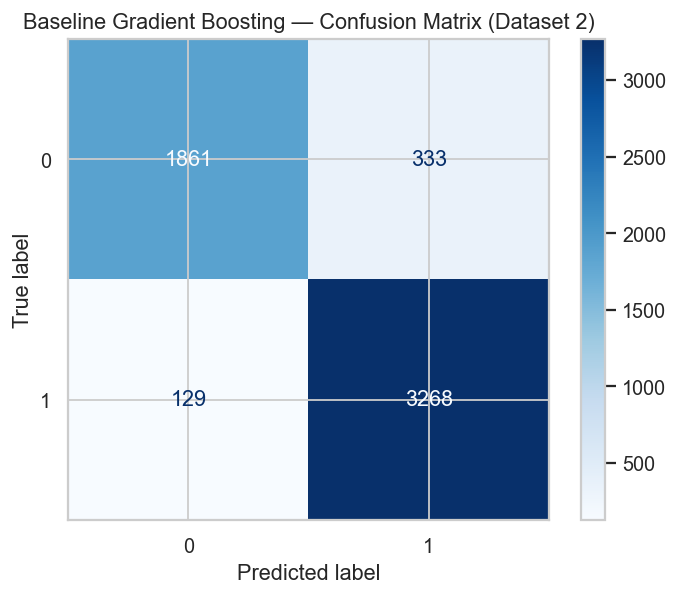

In [4]:
# --- Section 4: Baseline Gradient Boosting ---
gb_baseline = GradientBoostingClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=3,
    random_state=RANDOM_STATE
)

gb_baseline.fit(X_train.toarray(), y_train)
y_pred = gb_baseline.predict(X_test.toarray())

acc = accuracy_score(y_test, y_pred)
f1  = f1_score(y_test, y_pred)

print(f"Baseline GBC — Accuracy: {acc:.3f} | F1: {f1:.3f}\n")
print(classification_report(y_test, y_pred, digits=3))

ConfusionMatrixDisplay.from_estimator(gb_baseline, X_test.toarray(), y_test, cmap="Blues")
plt.title("Baseline Gradient Boosting — Confusion Matrix (Dataset 2)")
plt.show()

In [5]:
# --- Section 5: Helper Functions ---
def evaluate_model(model, Xtr, ytr, Xte, yte):
    model.fit(Xtr.toarray(), ytr)
    pred = model.predict(Xte.toarray())
    return accuracy_score(yte, pred), f1_score(yte, pred)

def plot_metric_curve(xvals, accs, f1s, xlabel, title):
    fig, ax = plt.subplots()
    sns.lineplot(x=xvals, y=accs, marker="o", label="Accuracy", ax=ax)
    sns.lineplot(x=xvals, y=f1s, marker="s", label="F1", ax=ax)
    ax.set_xlabel(xlabel)
    ax.set_ylabel("Score")
    ax.set_title(title)
    ax.legend()
    plt.show()

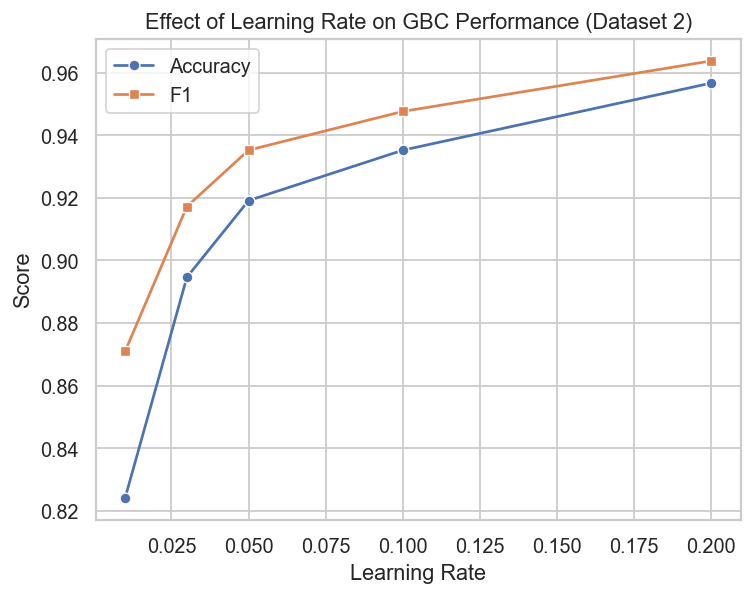

,learning_rate,accuracy,f1
0,0.01,0.824182,0.871014
1,0.03,0.894652,0.917240
2,0.05,0.919156,0.935262
3,0.10,0.935253,0.947642
4,0.20,0.956716,0.963794


In [6]:
# --- Section 6: Learning Rate Sweep ---
lrs = [0.01, 0.03, 0.05, 0.1, 0.2]
accs, f1s = [], []

for lr in lrs:
    model = GradientBoostingClassifier(n_estimators=200, learning_rate=lr, max_depth=3, random_state=RANDOM_STATE)
    acc, f1 = evaluate_model(model, X_train, y_train, X_test, y_test)
    accs.append(acc); f1s.append(f1)

plot_metric_curve(lrs, accs, f1s, "Learning Rate", "Effect of Learning Rate on GBC Performance (Dataset 2)")
pd.DataFrame({"learning_rate": lrs, "accuracy": accs, "f1": f1s})

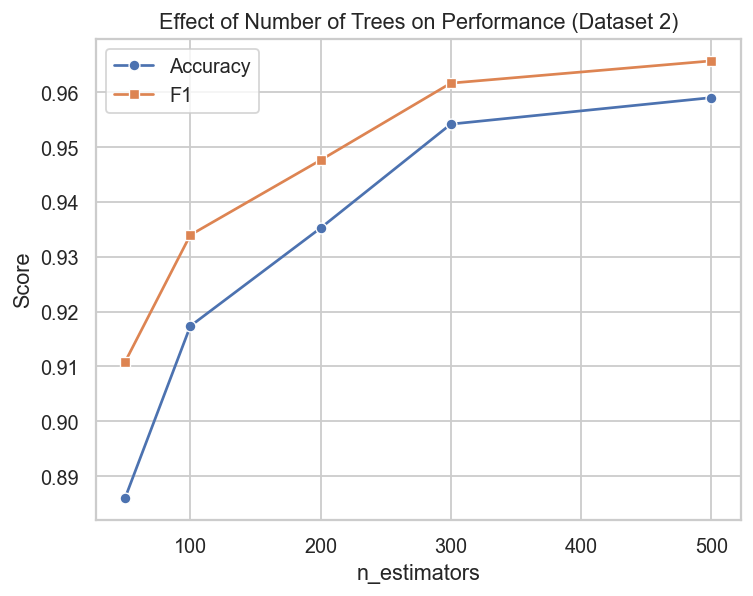

,n_estimators,accuracy,f1
0,50,0.886067,0.910872
1,100,0.917367,0.933981
2,200,0.935253,0.947642
3,300,0.954212,0.961688
4,500,0.959041,0.965744


In [7]:
# --- Section 7: Number of Trees Sweep ---
trees = [50, 100, 200, 300, 500]
accs, f1s = [], []

for n in trees:
    model = GradientBoostingClassifier(n_estimators=n, learning_rate=0.1, max_depth=3, random_state=RANDOM_STATE)
    acc, f1 = evaluate_model(model, X_train, y_train, X_test, y_test)
    accs.append(acc); f1s.append(f1)

plot_metric_curve(trees, accs, f1s, "n_estimators", "Effect of Number of Trees on Performance (Dataset 2)")
pd.DataFrame({"n_estimators": trees, "accuracy": accs, "f1": f1s})

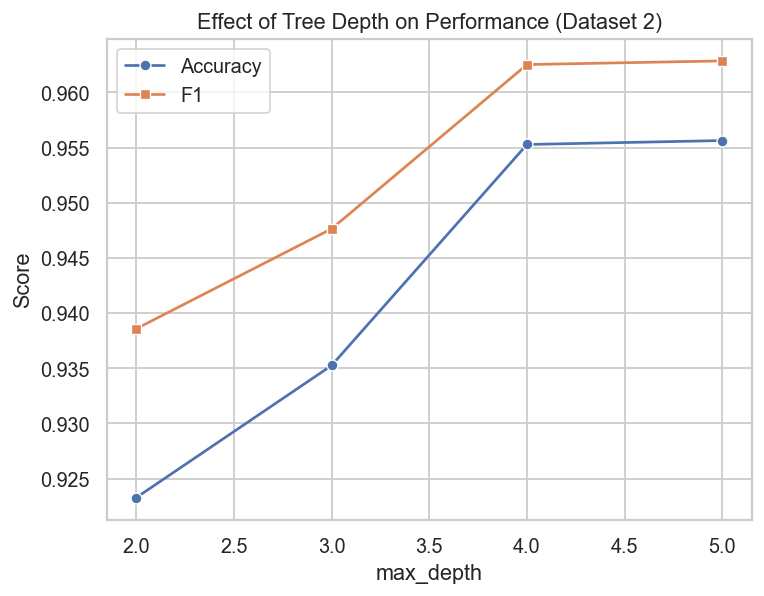

,max_depth,accuracy,f1
0,2,0.923270,0.938583
1,3,0.935253,0.947642
2,4,0.955285,0.962530
3,5,0.955643,0.962863


In [8]:
# --- Section 8: Tree Depth Sweep ---
depths = [2, 3, 4, 5]
accs, f1s = [], []

for d in depths:
    model = GradientBoostingClassifier(n_estimators=200, learning_rate=0.1, max_depth=d, random_state=RANDOM_STATE)
    acc, f1 = evaluate_model(model, X_train, y_train, X_test, y_test)
    accs.append(acc); f1s.append(f1)

plot_metric_curve(depths, accs, f1s, "max_depth", "Effect of Tree Depth on Performance (Dataset 2)")
pd.DataFrame({"max_depth": depths, "accuracy": accs, "f1": f1s})

In [9]:
# --- Section 9: Regularization Sweep ---
settings = [(1.0, 1), (0.8, 3), (0.6, 5), (0.5, 10)]
rows = []

for subsample, min_leaf in settings:
    model = GradientBoostingClassifier(
        n_estimators=300,
        learning_rate=0.05,
        max_depth=3,
        subsample=subsample,
        min_samples_leaf=min_leaf,
        random_state=RANDOM_STATE
    )
    acc, f1 = evaluate_model(model, X_train, y_train, X_test, y_test)
    rows.append((subsample, min_leaf, acc, f1))

reg_df = pd.DataFrame(rows, columns=["subsample", "min_samples_leaf", "accuracy", "f1"])
reg_df

,subsample,min_samples_leaf,accuracy,f1
0,1.0,1,0.930782,0.944132
1,0.8,3,0.932570,0.945622
2,0.6,5,0.931855,0.945156
3,0.5,10,0.931497,0.944868


Final GBC — Accuracy: 0.931 | F1: 0.944


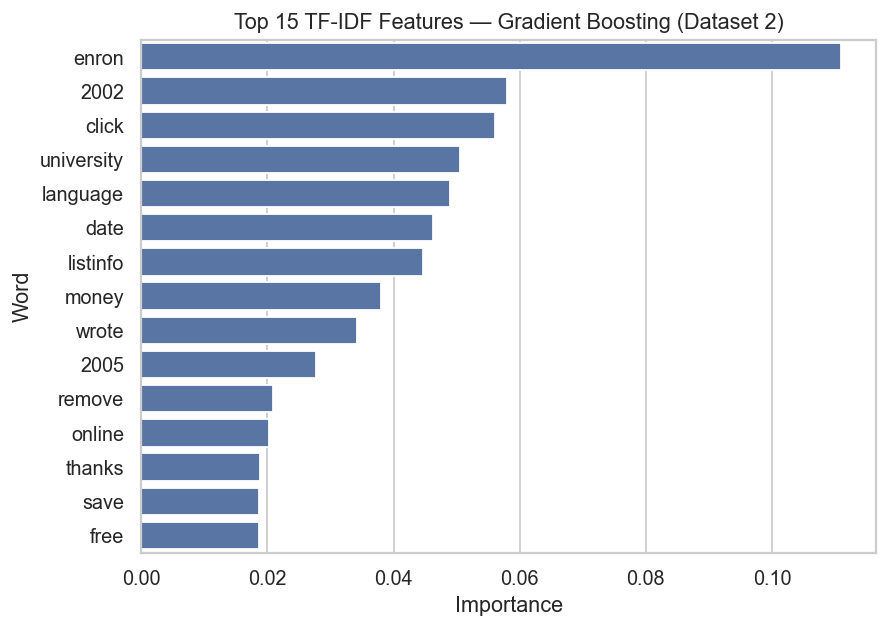

In [10]:
# --- Section 10: Final Model + Feature Importance ---
gb_final = GradientBoostingClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=3,
    subsample=0.8,
    min_samples_leaf=5,
    random_state=RANDOM_STATE
)
gb_final.fit(X_train.toarray(), y_train)
y_hat = gb_final.predict(X_test.toarray())

print(f"Final GBC — Accuracy: {accuracy_score(y_test, y_hat):.3f} | F1: {f1_score(y_test, y_hat):.3f}")

# Top 15 word features
importances = pd.Series(gb_final.feature_importances_, index=vectorizer.get_feature_names_out())
topk = importances.sort_values(ascending=False).head(15)

plt.figure(figsize=(7,5))
sns.barplot(x=topk.values, y=topk.index)
plt.title("Top 15 TF-IDF Features — Gradient Boosting (Dataset 2)")
plt.xlabel("Importance")
plt.ylabel("Word")
plt.tight_layout()
plt.show()

In [11]:
# --- Section 11: Compact Metrics Summary ---
summary_rows = []

def quick_eval(name, model):
    acc, f1 = evaluate_model(model, X_train, y_train, X_test, y_test)
    summary_rows.append((name, acc, f1))

quick_eval("Baseline (100, lr=0.1, depth=3)", gb_baseline)
quick_eval("n=200, lr=0.05, depth=3", GradientBoostingClassifier(n_estimators=200, learning_rate=0.05, max_depth=3, random_state=RANDOM_STATE))
quick_eval("n=300, lr=0.1, depth=3", GradientBoostingClassifier(n_estimators=300, learning_rate=0.1, max_depth=3, random_state=RANDOM_STATE))
quick_eval("Final tuned", gb_final)

metrics_df = pd.DataFrame(summary_rows, columns=["model", "accuracy", "f1"]).sort_values("f1", ascending=False)
metrics_df.reset_index(drop=True, inplace=True)
metrics_df

,model,accuracy,f1
0,"n=300, lr=0.1, depth=3",0.954212,0.961688
1,Final tuned,0.930960,0.944380
2,"n=200, lr=0.05, depth=3",0.919156,0.935262
3,"Baseline (100, lr=0.1, depth=3)",0.917367,0.933981


#### **Conclusions**

Gradient Boosting proved highly effective in identifying phishing emails using TF-IDF features.
Performance consistently improved as the learning rate, number of trees, and tree depth increased—showing a similar pattern to Dataset 1 (Web Page Phishing Detection), though with slightly lower overall scores due to text variability.

**-Performance trend:**

Moderate learning rates (0.05–0.1) and around 300 estimators achieved the best balance between bias and variance.
The top configuration (n = 300, lr = 0.1, depth = 3) reached Accuracy ≈ 0.95 and F1 ≈ 0.96, while deeper trees yielded minimal additional gain.

**-Regularization effect:**

Introducing subsampling and minimum-leaf constraints (subsample = 0.8, min_samples_leaf = 5) maintained strong generalization with only a small performance trade-off (Final Tuned F1 ≈ 0.94).

**-Feature importance:**

The most influential TF-IDF terms—“enron,” “click,” “2002,” “university,” “language,” “date,” and “money”—indicate that the model learned discriminative lexical patterns typical of phishing or spam contexts (e.g., hyperlinks, financial or institutional references).

**Overall conclusion:**

Gradient Boosting effectively captures phishing intent within textual data, achieving robust F1 scores around 0.96.
Just as in Dataset 1, tuning the learning rate and the number of estimators provides the largest performance gains, confirming the algorithm’s sensitivity to iterative learning parameters and its strong capability for phishing-related classification tasks.